In [1]:
from ananke.configurations.collection import HDF5StorageConfiguration
from ananke.models.collection import Collection
from ananke.configurations.collection import RedistributionConfiguration
from ananke.configurations.events import EventRedistributionMode
from ananke.configurations.collection import MergeConfiguration
import multiprocessing
lock = multiprocessing.Lock()

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot(hits):
    """
    Generate and display a histogram plot of 'time' for different 'type' values 
    within a specific 'record_id' in the given DataFrame.
    """
    # Select the first unique record_id
    record = hits['record_id'].unique()[0]
    
    # Get all unique types
    types = hits['type'].unique()
    
    # Filter hits for the selected record_id
    hit = hits[hits['record_id'] == record]
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 5))
    
    interval = np.arange(hit['time'].min(), hit['time'].max(), 100)

    # Iterate through each unique type and plot its histogram
    for t in types:
        y, x = np.histogram(hit[hit['type'] == t]['time'], bins=interval)
        x = (x[:-1] + x[1:]) / 2  # Convert bin edges to bin centers
        ax.plot(x, y+1, label=f'Type {t}')
        
    y, x = np.histogram(hit['time'], bins=interval)
    x = (x[:-1] + x[1:]) / 2  # Convert bin edges to bin centers
    ax.plot(x, y+1, label=f'Type : All')

    # Labeling and legend
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Histogram for Record ID {record}")
    ax.legend()

    # Show the plot each time the function is called
    plt.yscale('log')
    plt.show()

# Example usage:
#plot(hits)  # This will display the plot each time the function is called


In [41]:
from ananke.configurations.events import EventRedistributionMode
configuration = MergeConfiguration.parse_obj(
    {
        'in_collections': [
            {
                'type': 'hdf5',
                'data_path': f'0R.h5',
                
            }
        ],
        'out_collection': {
                'type': 'hdf5',
                'data_path': f'0R3.h5',
                'read_only':False
        },
        'redistribution': {
            'interval': {
                'start': 0,
                'end': 1000000
            },
            'mode': EventRedistributionMode.CONTAINS_HIT
            
        }
    })

c=Collection.from_merge(configuration)

100it [00:25,  3.95it/s]              
100%|██████████| 20/20 [03:10<00:00,  9.53s/it]
100it [00:21,  4.56it/s]              


In [39]:
with c:
    hits=c.storage.get_hits().df

In [14]:
path= '0R.h5'
c=HDF5StorageConfiguration(data_path=path)
c=Collection(c)
with c:
    hits=c.storage.get_hits().df

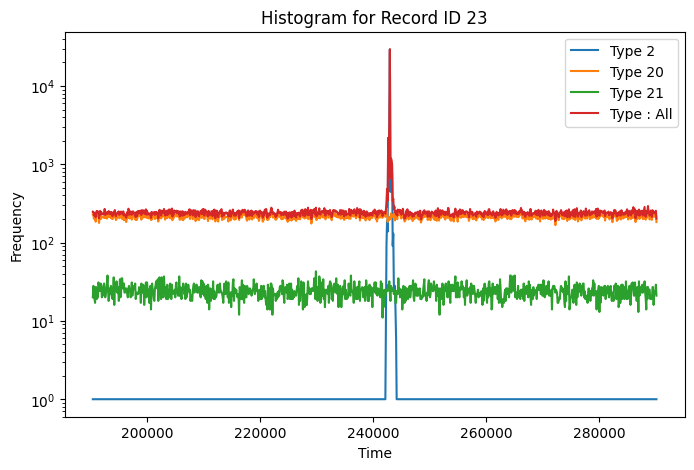

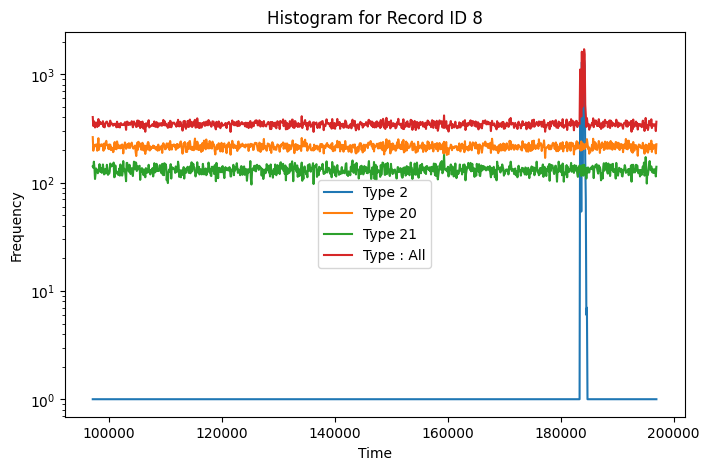

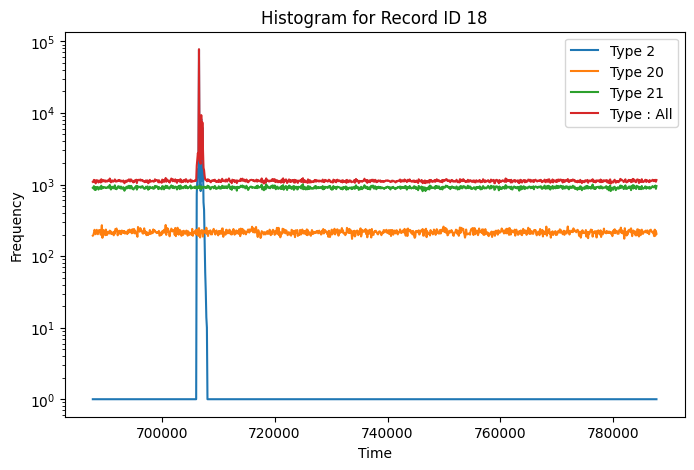

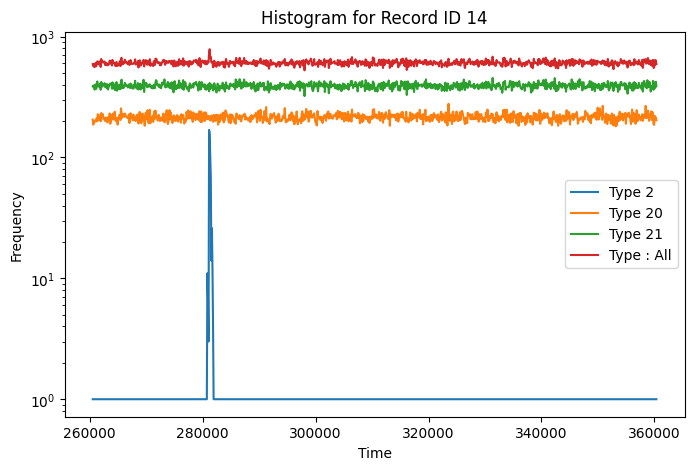

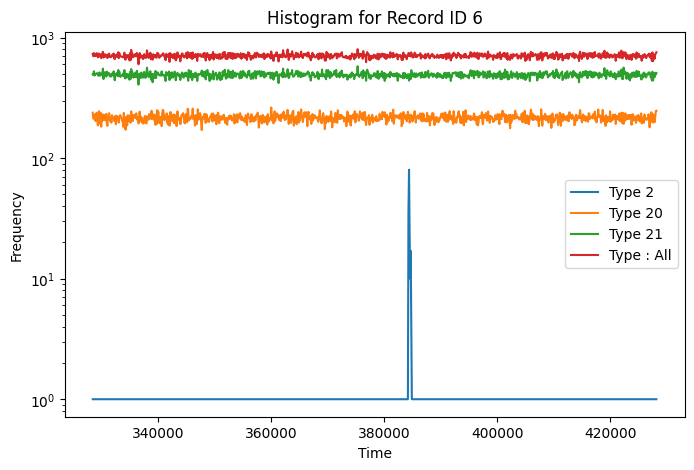

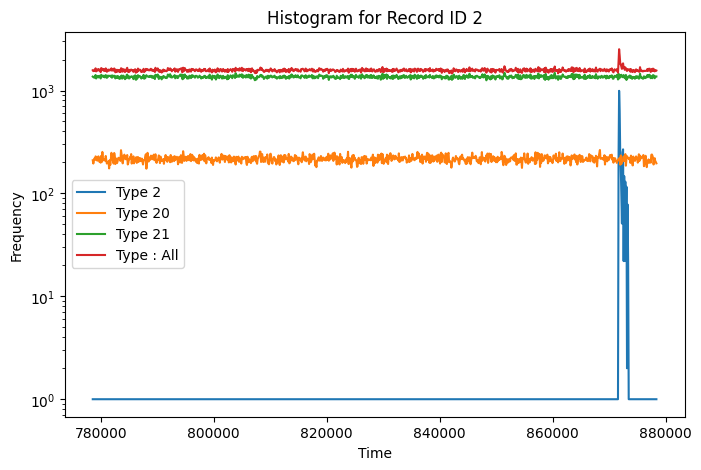

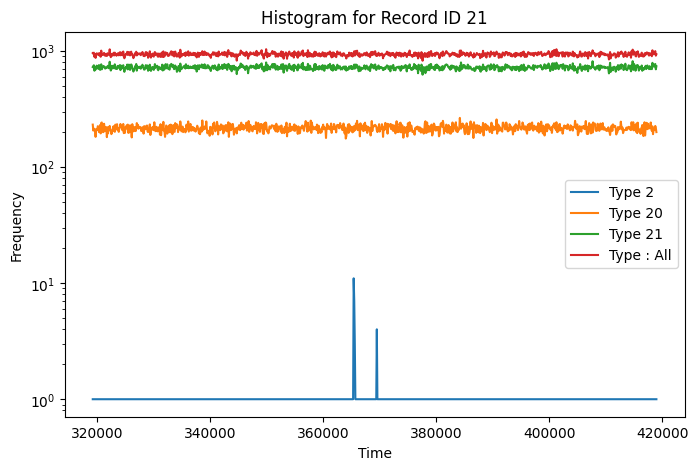

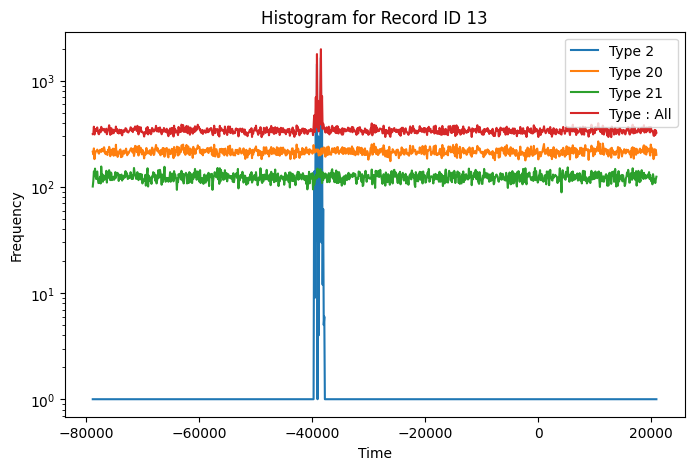

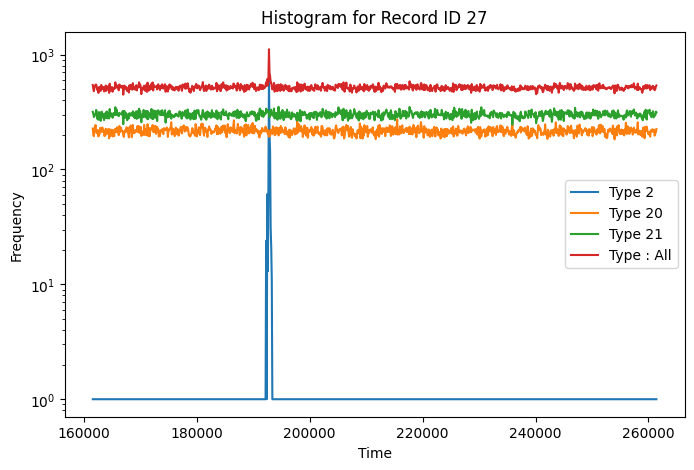

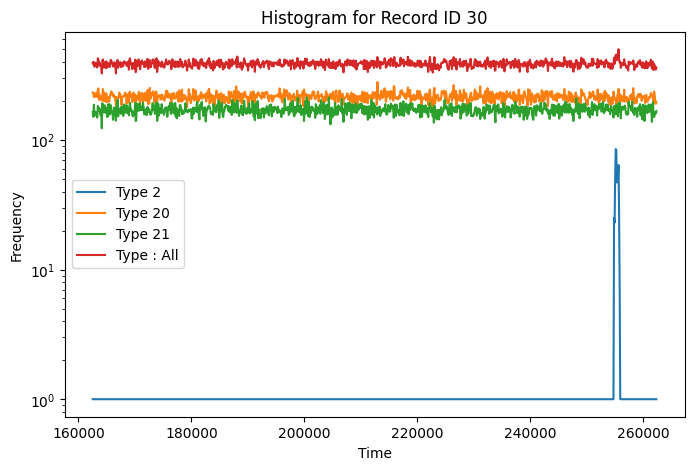

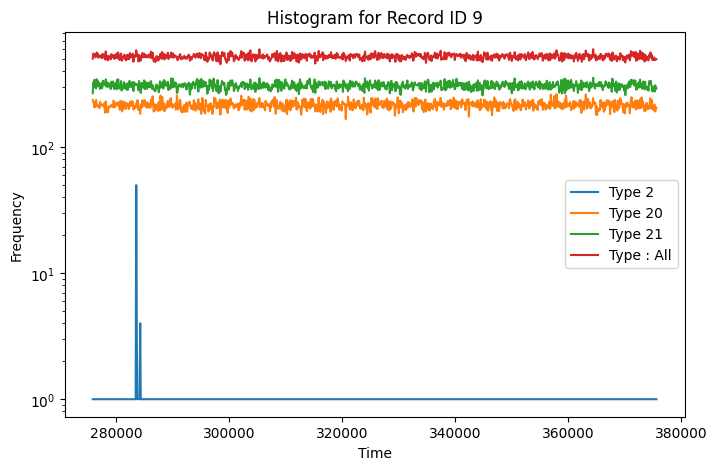

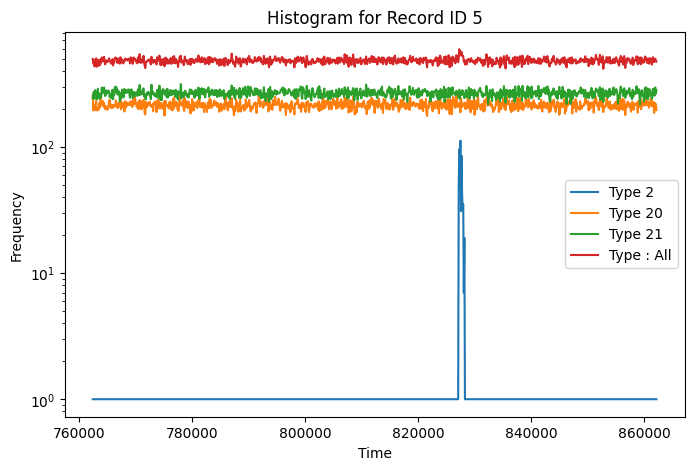

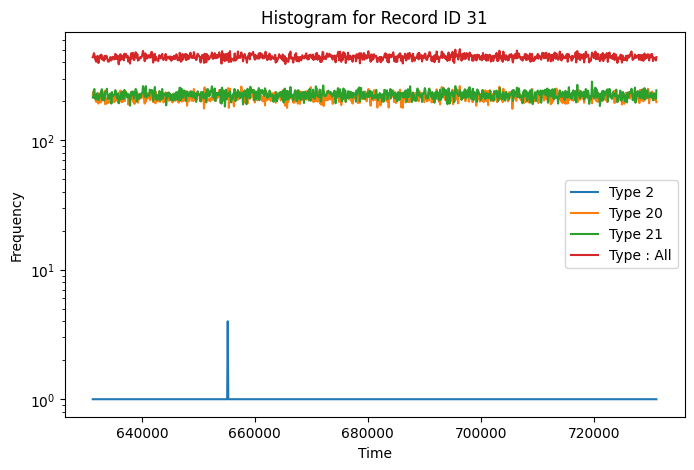

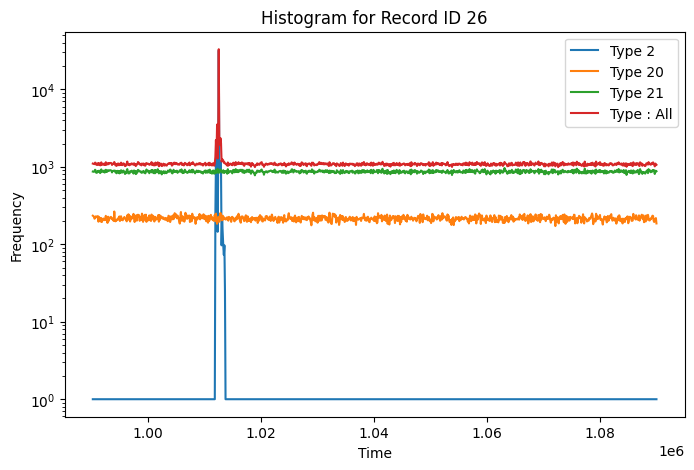

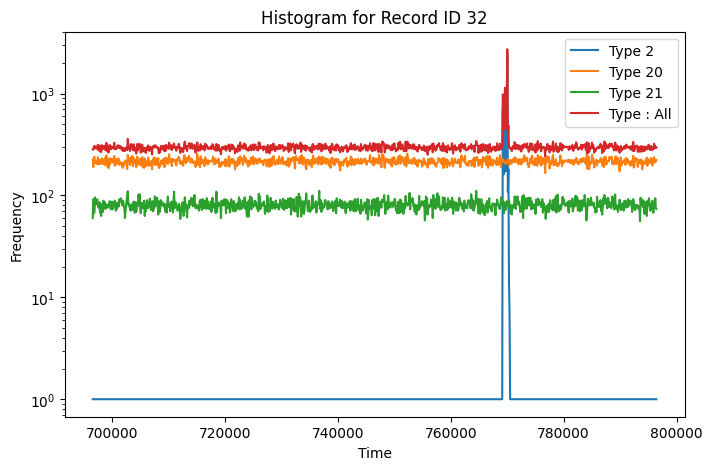

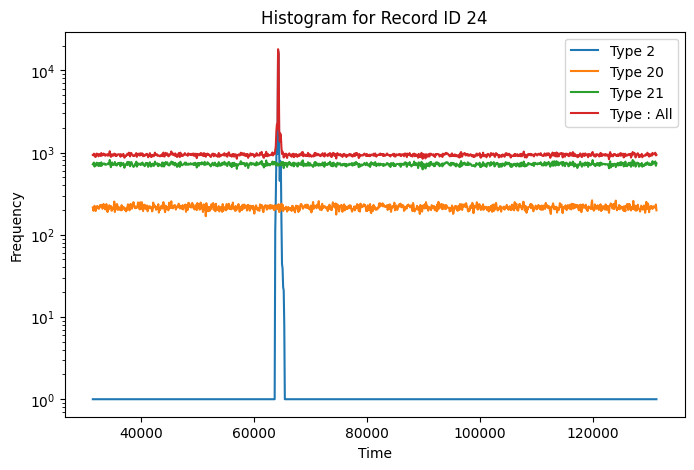

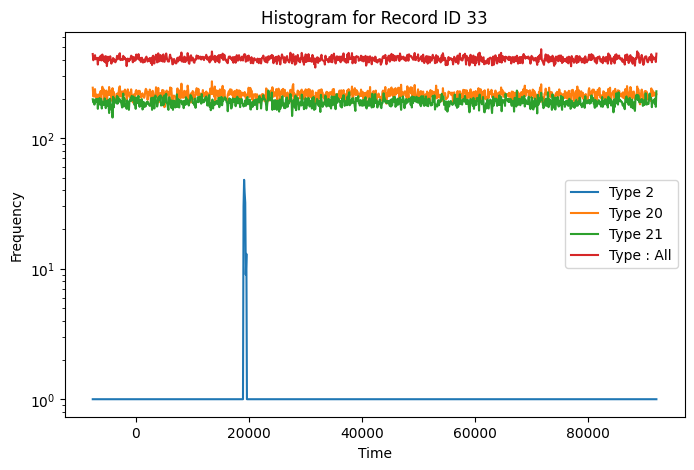

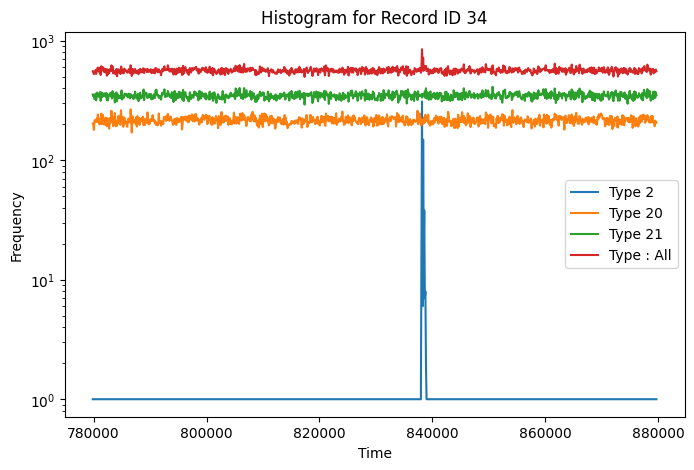

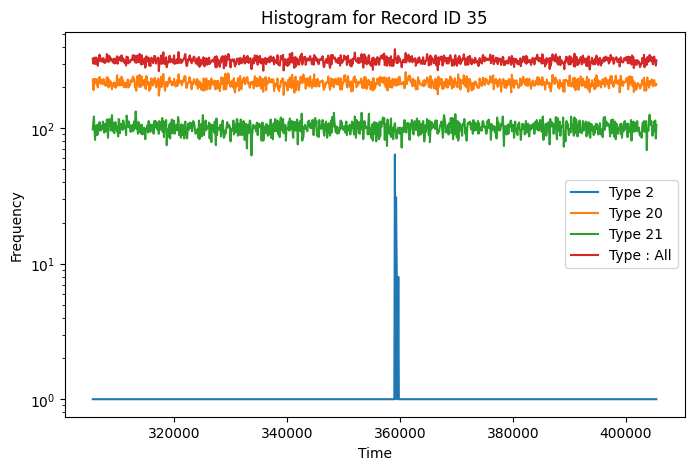

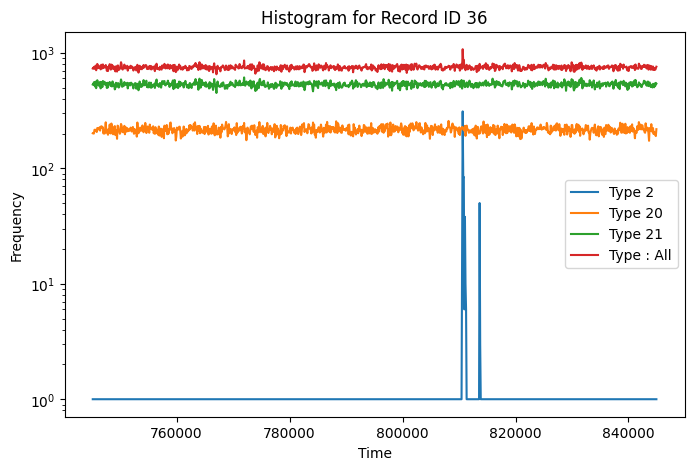

In [15]:
for r in hits['record_id'].unique():
    plot(hits[hits['record_id']==r])

In [46]:
hits['record_id'].unique()

array([23,  6, 15, 13,  5,  0, 20, 12, 27, 31,  7,  1, 32, 25, 33, 24, 34,
       35, 36, 37])

In [41]:
import with c:
    c.redistribute(configuration.redistribution)

100%|██████████| 20/20 [03:44<00:00, 11.24s/it]


In [27]:
import time

In [48]:
def parallel(file):
        configuration = MergeConfiguration.parse_obj(
        {
            'in_collections': [
                {
                    'type': 'hdf5',
                    'data_path': f'0R1.h5',

                }
            ],
            'out_collection': {
                    'type': 'hdf5',
                    'data_path': f'0R1e.h5',
                    'read_only':"False"
            },
            'redistribution': {
                'interval': {
                    'start': 0,
                    'end': 1000000
                },
                'mode': EventRedistributionMode.CONTAINS_HIT

            }
        })

        Collection.from_merge(configuration)
    return None

In [31]:
import os
import sys
import multiprocessing
import logging
from tqdm import tqdm
from ananke.models.collection import Collection
from ananke.configurations.collection import MergeConfiguration
from ananke.schemas.event import RecordType

# Set up logging
logging.basicConfig(
    filename="merge_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

def merger(file, base_path):
    """Merges data from HDF5 files."""
    #print('entered merge')
    try:
        name = os.path.basename(file)
        logging.info(f"Starting processing for {name}")

        # Define paths
        data_path = f"{base_path}/LargeCascades/20records/{file}"
        en_path = f"{base_path}/LargeElectrical/100000s/{name}"
        bn_path = f"{base_path}/LargeBio/100000s/{name}"
        save_path = f"/viper/ptmp/arego/CMerge/{name}"
        #print('try')
        # Skip if file already exists
        if os.path.isfile(save_path):
            print('skip')
            logging.info(f"Skipped {name}: Already exists.")
            return f"Skipped {name}: Already exists."

        # Create merge configuration
        configuration = MergeConfiguration.parse_obj(
            {
                "in_collections": [
                    {"type": "hdf5", "data_path": data_path,"read_only": "False"},
                    {"type": "hdf5", "data_path": en_path,"read_only": "False"},
                    {"type": "hdf5", "data_path": bn_path,"read_only": "False"},
                ],
                "out_collection": {"type": "hdf5", "data_path": save_path, "read_only": "False"},
                "content": [
                    {
                        "primary_type": RecordType.CASCADE.value,
                        "secondary_types": [RecordType.ELECTRICAL.value, RecordType.BIOLUMINESCENCE],
                        "number_of_records": 20,
                        "interval": {"start": 0, "end": 1000000},
                    },
                ],
            }
        )

        # Perform the merge operation
        Collection.from_merge(configuration)

        logging.info(f"Completed {name}")
        return f"Processed {name}"

    except Exception as e:
        logging.error(f"Error processing {file}: {str(e)}")
        return f"Error processing {file}: {str(e)}"


def update_progress_bar(total_files, progress_queue):
    """Updates the progress bar based on completed tasks."""
    with tqdm(total=total_files, desc="Merging Files") as pbar:
        for _ in range(total_files):
            progress_queue.get()  # Wait for an update
            pbar.update(1)

def process_files(files, base_path, num_workers=32):
    """Processes files in parallel using multiprocessing.Pool."""
    manager = multiprocessing.Manager()
    progress_queue = manager.Queue()
    total_files = len(files)
    print('good till here')
    # Start progress bar in a separate process
    progress_process = multiprocessing.Process(target=update_progress_bar, args=(total_files, progress_queue))
    progress_process.start()

    def update_progress(_):
        """Callback function to update progress bar after each merge operation."""
        progress_queue.put(1)

    with multiprocessing.Pool(processes=num_workers) as pool:
        for file in files:
            pool.apply_async(merger, args=(file, base_path), callback=update_progress)

        pool.close()
        pool.join()

    progress_process.join()
    print("Merging complete!")

if __name__ == "__main__":
    #import argparse

    #parser = argparse.ArgumentParser(description="Merge HDF5 files in parallel.")
    #parser.add_argument("files", nargs="+", help="List of HDF5 files to process.")
    #parser.add_argument("--num_workers", type=int, default=8, help="Number of parallel workers.")
    #args = parser.parse_args()
    
    files=os.listdir('../LargeCascades/20records/')
    files=[file for file in files if '.h5' in file][:10]

    print(f"Processing {len(files)} files...")
    t=time.time()
    # Run parallel processing
    process_files(files, base_path="/raven/u/arego/project/Experimenting/data/", num_workers=8)
    print(time.time()-t)
    
    files=os.listdir('../LargeCascades/20records/')
    files=[file for file in files if '.h5' in file][20:30]
    t=time.time()
    # Run parallel processing
    process_files(files, base_path="/raven/u/arego/project/Experimenting/data/", num_workers=8)
    print(time.time()-t)

Processing 10 files...
good till here


100it [00:09, 11.04it/s]              00:00<?, ?it/s]
100it [00:09, 10.60it/s]              
100it [00:12,  7.81it/s]              ]
100it [00:20,  4.95it/s]              ]
100it [00:21,  4.57it/s]              
100%|██████████| 100/100 [00:23<00:00,  4.31it/s]
100it [00:44,  2.23it/s]              
100%|██████████| 100/100 [00:21<00:00,  4.59it/s]
100it [00:48,  2.06it/s]              ]
100it [00:18,  5.44it/s]              ]
100it [00:25,  3.98it/s]              
100it [00:29,  3.40it/s]              .72s/it]
100%|██████████| 100/100 [00:25<00:00,  3.97it/s]
100it [00:23,  4.20it/s]              .88s/it]
100it [01:14,  1.34it/s]              
100%|██████████| 100/100 [00:24<00:00,  4.07it/s]
100it [00:28,  3.56it/s]              .34s/it]
100%|██████████| 100/100 [00:25<00:00,  3.85it/s]
100it [00:31,  3.16it/s]              3.45s/it]
100it [00:30,  3.25it/s]              2.96s/it]
100%|██████████| 20/20 [01:01<00:00,  3.09s/it]
100it [00:14,  6.94it/s]              .86s/it]]23, 122.6

Merging complete!
352.06549286842346
good till here


100it [00:08, 12.23it/s]              00:00<?, ?it/s]
100it [00:08, 11.52it/s]              
100it [00:24,  4.00it/s]              ]
100it [00:30,  3.33it/s]              ]
100it [00:30,  3.33it/s]              
100%|██████████| 100/100 [00:22<00:00,  4.42it/s]
100it [00:49,  2.02it/s]              
100%|██████████| 100/100 [00:24<00:00,  4.05it/s]
100it [00:20,  4.77it/s]              
100it [00:25,  3.96it/s]              
100it [01:06,  1.50it/s]              .67s/it]
100it [01:10,  1.41it/s]              ]09s/it]
100%|██████████| 100/100 [00:24<00:00,  4.07it/s]
100it [00:20,  4.78it/s]              .75s/it]
100it [00:20,  4.77it/s]
100it [00:34,  2.89it/s]              .95s/it]
100%|██████████| 100/100 [00:25<00:00,  3.91it/s]
100it [00:18,  5.39it/s]              .00s/it]
100%|██████████| 100/100 [00:25<00:00,  3.99it/s]
100it [00:22,  4.47it/s]              .84s/it]]
100it [00:31,  3.23it/s]              4.33s/it]
100%|██████████| 20/20 [01:13<00:00,  3.70s/it]12, 134.73s/it]
10

Merging complete!
324.5805757045746


In [30]:
files=os.listdir('../LargeCascades/20records/')
files=[file for file in files if '.h5' in file][:10]

print(f"Processing {len(files)} files...")
t=time.time()
# Run parallel processing
process_files(files, base_path="/raven/u/arego/project/Experimenting/data/", num_workers=8)
print(time.time()-t)

Processing 10 files...
good till here


100it [00:09, 11.07it/s]              00:00<?, ?it/s]
100it [00:09, 10.67it/s]              
100it [00:12,  8.10it/s]              ]
100it [00:20,  4.88it/s]              ]
100it [00:22,  4.51it/s]              
100%|██████████| 100/100 [00:22<00:00,  4.35it/s]
100it [00:42,  2.33it/s]              
100%|██████████| 100/100 [00:23<00:00,  4.34it/s]
100it [00:48,  2.06it/s]              
100it [00:18,  5.29it/s]              ]
100it [00:23,  4.21it/s]              
100it [00:29,  3.41it/s]              .60s/it]
100%|██████████| 100/100 [00:25<00:00,  3.94it/s]
100it [00:23,  4.28it/s]              .40s/it]
100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
100it [01:16,  1.31it/s]              .04s/it]
100it [00:28,  3.57it/s]              .52s/it]
100%|██████████| 100/100 [00:26<00:00,  3.83it/s]
100it [00:31,  3.15it/s]              5.58s/it]
100it [00:30,  3.25it/s]              4.15s/it]
100%|██████████| 20/20 [01:02<00:00,  3.13s/it]
100it [00:14,  7.05it/s]              4.23s/it]28

Merging complete!
350.3165376186371


In [ ]:
merger()